In [9]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [10]:
### Load datamodel from .p file
run_name = 'approach_curve_1'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from Y:\expdata-e6\analysis\2021\03\24\approach_curve_1\approach_curve_1-datamodel.p


In [11]:
### Information about run:
### Note that molasses intensity is less than 5 for the first two frames,
### so better not use mol_freq = 4.5 and 5 for the 1/delta^2 fit!

tweezer_freq_list = [108,110,112,114,116] #110 is a fake one for reference.
num_tweezers = len(tweezer_freq_list)

mol_att_list = [2.5,5,7.5]
tweezer_att_list = [2,4,6]

num_points = datamodel.num_points #len(tweezer_att_list) * len(mol_att_list)


mol_freq_list = [5,5.5,6,6.5,7,7.5,8,8.5,9,9.25,9.5]
num_frames = len(mol_freq_list) + 2

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

9 points
13 frames
5 tweezers
350 shots
38 complete loops


In [12]:
counts_array = np.zeros((num_frames,len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    mol_att_counter = point % len(mol_att_list)
    tweezer_att_counter = point // len(mol_att_list)
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,mol_att_counter,tweezer_att_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
print(counts_array.shape)

(13, 3, 3, 5, 38)


c:\python37-32\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\python37-32\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: Mean of empty slice


tweezer_att = 2, mol_att = 2.5
mean_in_theory:2.5, std_in_theory:1.118033988749895
mean:2.026315789473684, std:0.9864034112627006
_______________________________________________________________________________
tweezer_att = 2, mol_att = 5
mean_in_theory:2.5, std_in_theory:1.118033988749895
mean:2.5, std:1.0942433098048312
_______________________________________________________________________________
tweezer_att = 2, mol_att = 7.5
mean_in_theory:2.5, std_in_theory:1.118033988749895
mean:2.6578947368421053, std:1.1303542944691858
_______________________________________________________________________________
tweezer_att = 4, mol_att = 2.5
mean_in_theory:2.5, std_in_theory:1.118033988749895
mean:2.1052631578947367, std:1.165049664272561
_______________________________________________________________________________
tweezer_att = 4, mol_att = 5
mean_in_theory:2.5, std_in_theory:1.118033988749895
mean:2.1842105263157894, std:1.1665347504895527
______________________________________________

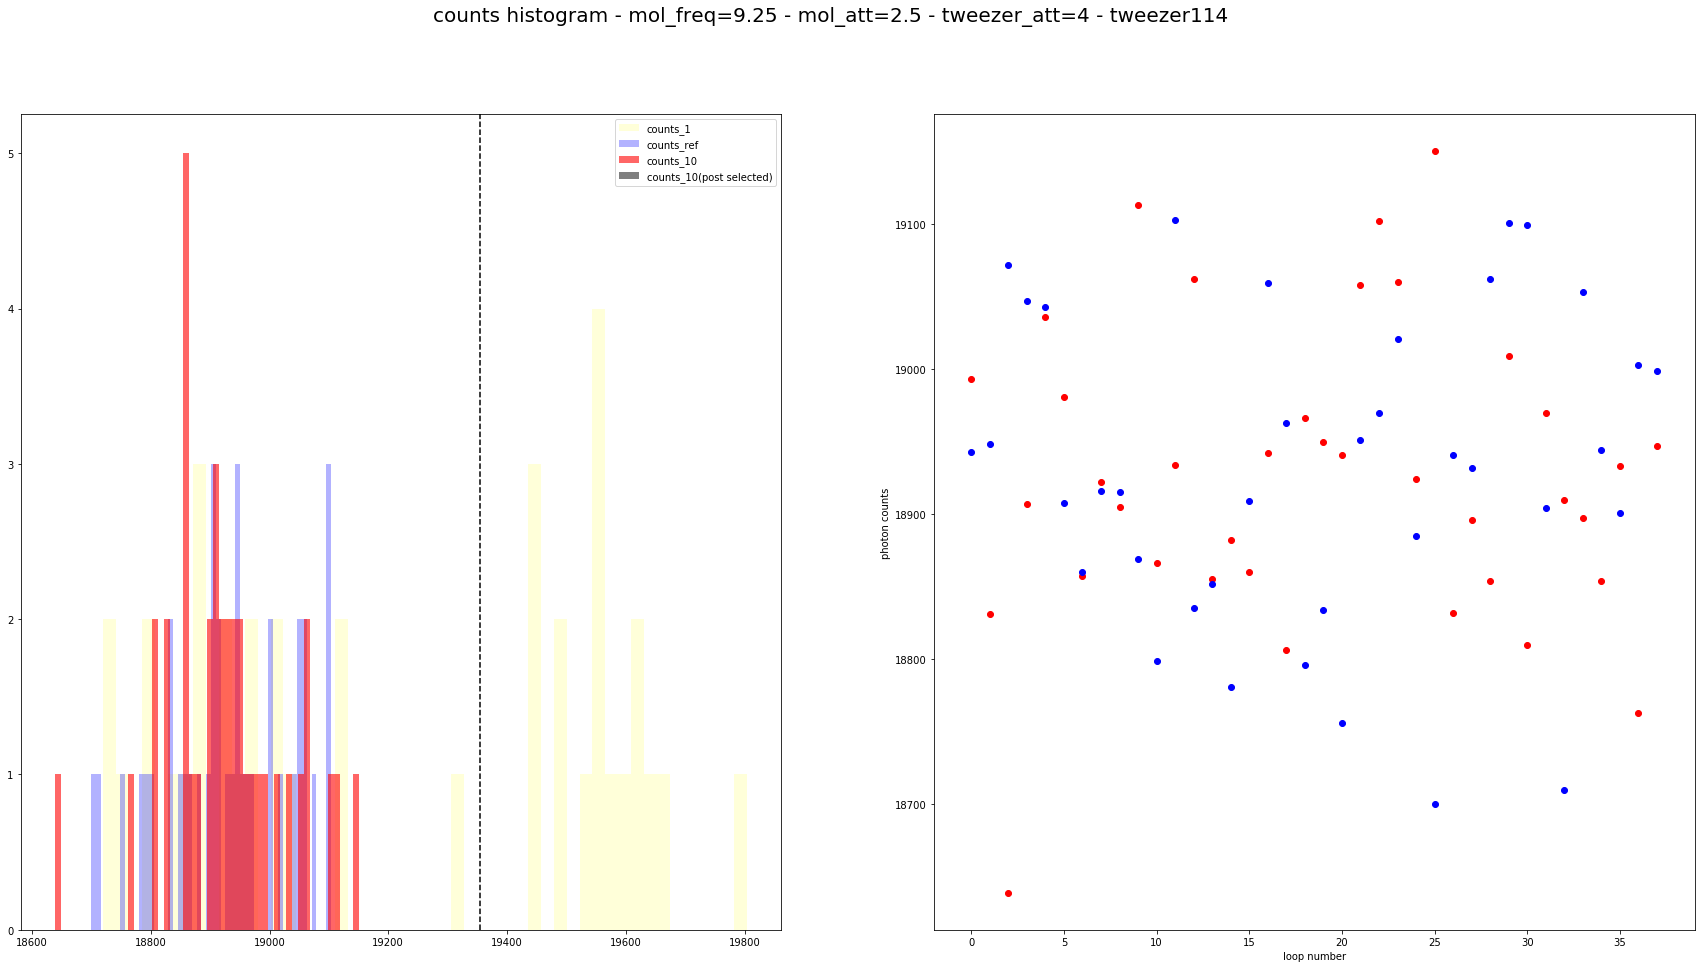

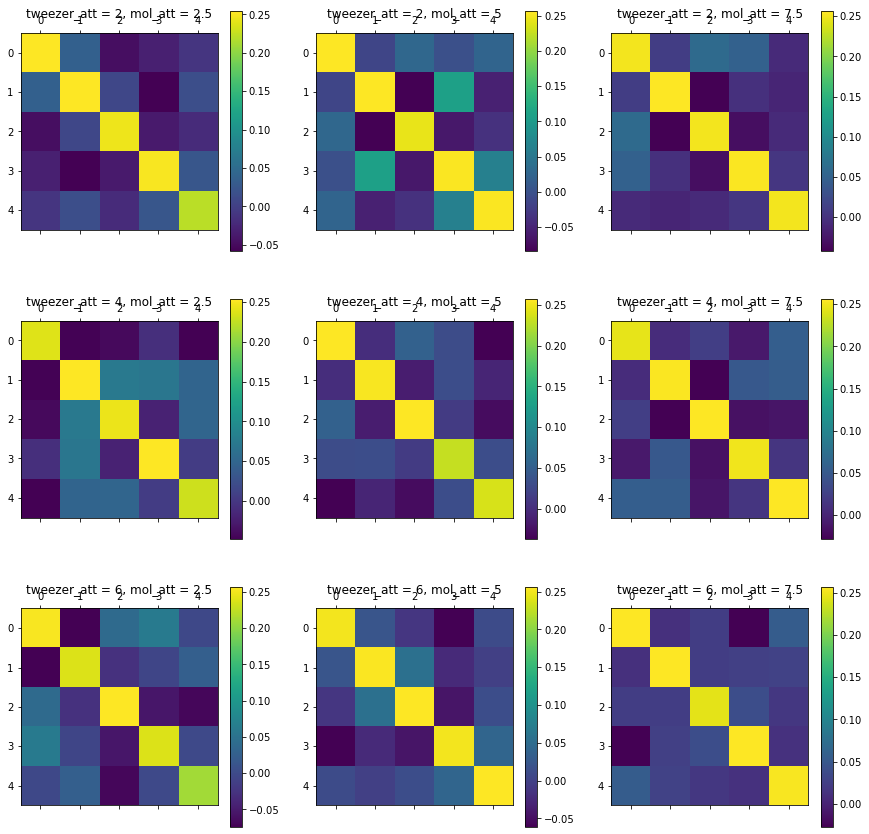

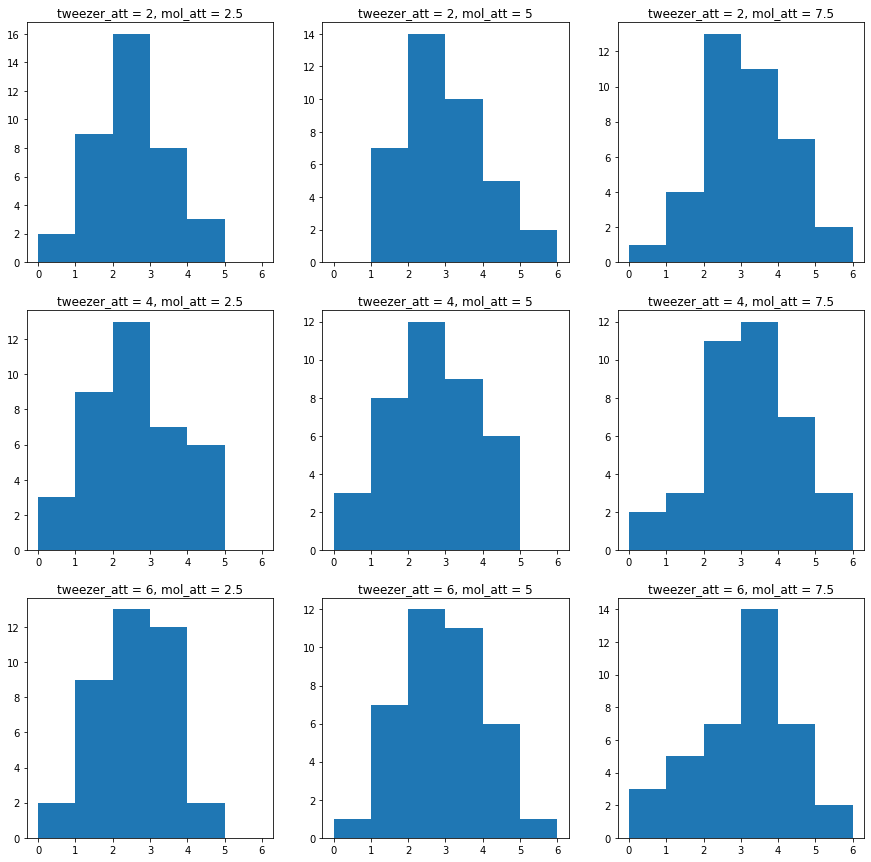

In [13]:
show_hist = False
# zeropeakHWFMper = 1.5
zeropeakHWFMper = 1.8
least_rep = 3
num_avg = 20 # number of loops to put in moving average

# Calculate nocav_brightness and nocav_fidelity for every shot!! 

nocav_brightness = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))
nocav_brightness_mean = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list)))
nocav_fidelity = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))
nocav_brightness_mov_avg = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))
nocav_brightness_mov_sigma = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))
nocav_fidelity_mov_avg = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))
nocav_fidelity_mov_sigma = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))
has_atom = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),len(tweezer_freq_list),num_loops))
atom_number = np.zeros((len(mol_freq_list),len(mol_att_list),len(tweezer_att_list),num_loops))



ref_counts = counts_array[len(mol_freq_list)+1,:,:,:,:]
base = np.nanmean(ref_counts,3)
upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area
upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)
mask_ref = ref_counts < upper_threshold
ref_counts = np.where(mask_ref, ref_counts, np.nan)

base = np.nanmean(ref_counts,3)
base = np.repeat(base[:,:,:,np.newaxis],num_loops,axis=3)
upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area
# upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)

counts_1 = counts_array[0,:,:,:,:]
counts_1 = np.where(mask_ref, counts_1, np.nan)

mol_freq_select = 9
mol_att_select = 0
tweezer_freq_select = 3
tweezer_att_select = 1

for frame_num in range(len(mol_freq_list)):
    mol_freq = mol_freq_list[frame_num]
    counts = counts_array[frame_num,:,:,:,:]
    counts = np.where(mask_ref, counts, np.nan)
    counts_next = counts_array[frame_num+1,:,:,:,:]
    counts_next = np.where(mask_ref, counts_next, np.nan)
    
    
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)
    
    
    atomcenter = np.nanmean(counts_post_selected,3)
    brightness_sigma = np.nanstd(counts_post_selected,3)
    lower_threshold = atomcenter - 2.5 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)
    low_threshold = atomcenter - 1.5 * brightness_sigma
    low_threshold = np.repeat(low_threshold[:,:,:,np.newaxis], num_loops, axis=3)
    mask1 = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    mask2 = np.greater(counts_post_selected, np.minimum(low_threshold, upper_threshold), where=~np.isnan(counts_post_selected))
    mask = np.logical_and(mask1, mask2)
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
#     if frame_num == mol_freq_select:
#         print(f"atom_center={atomcenter[mol_att_select,tweezer_att_select,tweezer_freq_select]},"
#               f" 3sigma={3*brightness_sigma[mol_att_select,tweezer_att_select,tweezer_freq_select]},"
#               f" lower_threshold={lower_threshold[mol_att_select,tweezer_att_select,tweezer_freq_select,0]},")
#     atomcenter = np.nanmean(counts_postpost_selected,3)
#     brightness_sigma = np.nanstd(counts_postpost_selected,3)
#     lower_threshold = atomcenter - 3 * brightness_sigma
#     lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)
#     mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
#     counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)

    
    if frame_num == mol_freq_select:
        fig0, ax0 = plt.subplots(1,2, figsize=(30, 15))
        fig0.suptitle(f'counts histogram - mol_freq={mol_freq_list[mol_freq_select]}'
                     f' - mol_att={mol_att_list[mol_att_select]}'
                     f' - tweezer_att={tweezer_att_list[tweezer_att_select]}'
                     f' - tweezer{tweezer_freq_list[tweezer_freq_select]}', size = 20)
        bins=50
        ax0[0].hist(counts_1[mol_att_select,tweezer_att_select,tweezer_freq_select,:], alpha=0.15, color='yellow', bins=bins)
        ax0[0].hist(ref_counts[mol_att_select,tweezer_att_select,tweezer_freq_select,:], alpha=0.3, color='b', bins=bins)
        n, bins, patches = \
        ax0[0].hist(counts[mol_att_select,tweezer_att_select,tweezer_freq_select,:], alpha=0.6, color='r', bins=bins)
        ax0[0].hist(counts_postpost_selected[mol_att_select,tweezer_att_select,tweezer_freq_select,:], alpha=0.5, color='black', bins=bins)
        ax0[0].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
        ax0[0].axvline(upper_threshold[mol_att_select,tweezer_att_select,tweezer_freq_select,0], linestyle='--', color='k')
        scatter_range = range(num_loops)
        ax0[1].scatter(scatter_range, counts[mol_att_select,tweezer_att_select,tweezer_freq_select,:], color='r')
        ax0[1].scatter(scatter_range, ref_counts[mol_att_select,tweezer_att_select,tweezer_freq_select,:], color='b')
        ax0[1].set_xlabel(f'loop number')
        ax0[1].set_ylabel('photon counts')
        fig0.show()     
    
    for mol_att_counter, mol_att in enumerate(mol_att_list):
        for tweezer_att_counter, tweezer_att in enumerate(tweezer_att_list):
            if show_hist == True and mol_att_counter==0:
                fig, ax = plt.subplots(2,num_tweezers, figsize=(30, 6))
                fig.suptitle(f'counts histogram - mol_freq={mol_freq} - mol_att={mol_att} - tweezer_att={tweezer_att}', size = 20)
                    
                for tweezer_freq_counter, tweezer_freq in enumerate(tweezer_freq_list):
#                     print([tweezer_freq_counter, tweezer_freq])
                    bins=50
                    ax[0,tweezer_freq_counter].hist(counts_1[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:], alpha=0.15, color='yellow', bins=bins)
                    ax[0,tweezer_freq_counter].hist(ref_counts[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:], alpha=0.3, color='b', bins=bins)
                    n, bins, patches = \
                    ax[0,tweezer_freq_counter].hist(counts[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:], alpha=0.6, color='r', bins=bins)
                    ax[0,tweezer_freq_counter].hist(counts_postpost_selected[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:], alpha=0.5, color='black', bins=bins)
                    ax[0,tweezer_freq_counter].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                    ax[0,tweezer_freq_counter].axvline(upper_threshold[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,0], linestyle='--', color='k')
#                     ax[0].axvline(lower_threshold, linestyle='--', color='b')

                    scatter_range = range(num_loops)
                    ax[1,tweezer_freq_counter].scatter(scatter_range, counts[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:], color='r')
                    ax[1,tweezer_freq_counter].scatter(scatter_range, counts_postpost_selected[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:], alpha=0.5, color='black')
                    ax[1,tweezer_freq_counter].scatter(scatter_range, ref_counts[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:], color='b')
                    ax[1,tweezer_freq_counter].set_xlabel(f'loop# - tweezer{tweezer_freq}')
                    ax[1,tweezer_freq_counter].set_ylabel('photon counts')
                    ax[1,tweezer_freq_counter].axhline(upper_threshold[mol_att_counter,tweezer_att_counter,tweezer_freq_counter,0], linestyle='--', color='k')
#                     ax[1,tweezer_freq_counter].legend(['counts', 'counts_ref'])
#                 plt.savefig(Path(save_path, f'mol_freq={mol_freq} - tweezer_att={tweezer_att_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
                plt.show()     
    
    has_atom[frame_num,:,:,:,:] = ~np.isnan(counts_postpost_selected)
    atom_number[frame_num,:,:,:] = np.count_nonzero(has_atom[frame_num,:,:,:,:], axis = 2)
    atomcenter = np.nanmean(counts_postpost_selected,3)
    brightness = counts_postpost_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,3)
    brightness_sigma = np.nanstd(brightness,3)
    
    lower_threshold = atomcenter - 3 * brightness_sigma

    nocav_brightness[frame_num,:,:,:,:] = brightness # num_frames x 
    nocav_fidelity[frame_num,:,:,:,:] = np.where(counts>upper_threshold,1,0)
for mol_freq_counter, mol_freq in enumerate(mol_freq_list):
    for mol_att_counter, mol_att in enumerate(mol_att_list):
        for tweezer_att_counter, mol_att in enumerate(tweezer_att_list):
            for tweezer_freq_counter, mol_att in enumerate(tweezer_freq_list):
                if np.count_nonzero(has_atom[mol_freq_counter,mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:])>=least_rep:
                    nocav_brightness_mean[mol_freq_counter,mol_att_counter,tweezer_att_counter,tweezer_freq_counter] \
                    = np.nanmean(nocav_brightness[mol_freq_counter,mol_att_counter,tweezer_att_counter,tweezer_freq_counter,:])
                else:
                    nocav_brightness_mean[mol_freq_counter,mol_att_counter,tweezer_att_counter,tweezer_freq_counter] = np.nan
nocav_brightness_sigma = np.nanstd(nocav_brightness,4)
nocav_fidelity_mean = np.nanmean(nocav_fidelity,4)
nocav_fidelity_sigma = np.sqrt(num_loops*nocav_fidelity_mean*(1-nocav_fidelity_mean))/(num_loops)


    
for loop in range(num_loops):
    start_temp = np.maximum(np.ceil(loop-num_avg/2).astype(int),0)
    end_temp = np.minimum(np.floor(loop+num_avg/2).astype(int), num_loops)
    nocav_brightness_mov_avg[:,:,:,:,loop] = np.nanmean(nocav_brightness[:,:,:,:,start_temp:end_temp],4)
    nocav_brightness_mov_sigma[:,:,:,:,loop] = np.nanstd(nocav_brightness[:,:,:,:,start_temp:end_temp],4)
    nocav_fidelity_mov_avg[:,:,:,:,loop] = np.nanmean(nocav_fidelity[:,:,:,:,start_temp:end_temp],4)
    nocav_fidelity_mov_sigma[:,:,:,:,loop] = np.nanstd(nocav_fidelity[:,:,:,:,start_temp:end_temp],4)
fig,axs = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
fig2,axs2 = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
for tweezer_att_counter, tweezer_att in enumerate(tweezer_att_list):
    for mol_att_counter, mol_att in enumerate(mol_att_list):
        covariance_matrix = np.zeros((num_tweezers,num_tweezers))
        axs[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        axs2[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        for ii in range(num_tweezers):
            for jj in range(num_tweezers):
                covariance_matrix[ii,jj] = np.cov(has_atom[0,mol_att_counter,tweezer_att_counter,ii,:],\
                                                  has_atom[0,mol_att_counter,tweezer_att_counter,jj,:])[0,1]
        cov_plot = axs[tweezer_att_counter,mol_att_counter].matshow(covariance_matrix)
        fig.colorbar(cov_plot, ax=axs[tweezer_att_counter,mol_att_counter])

        bins=num_tweezers+1
        axs2[tweezer_att_counter,mol_att_counter].hist(atom_number[0,mol_att_counter,tweezer_att_counter,:],bins=bins,range=(0,bins))
        print(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        print(f"mean_in_theory:{num_tweezers/2}, std_in_theory:{np.sqrt(num_tweezers/4)}")
        print(f"mean:{np.mean(atom_number[0,mol_att_counter,tweezer_att_counter,:])}, std:{np.std(atom_number[0,mol_att_counter,tweezer_att_counter,:])}")
        print("_______________________________________________________________________________")
#         for number_atom in range(num_tweezers+1):
#             print([number_atom, np.count_nonzero(atom_number[0,0,0,:]==number_atom)])

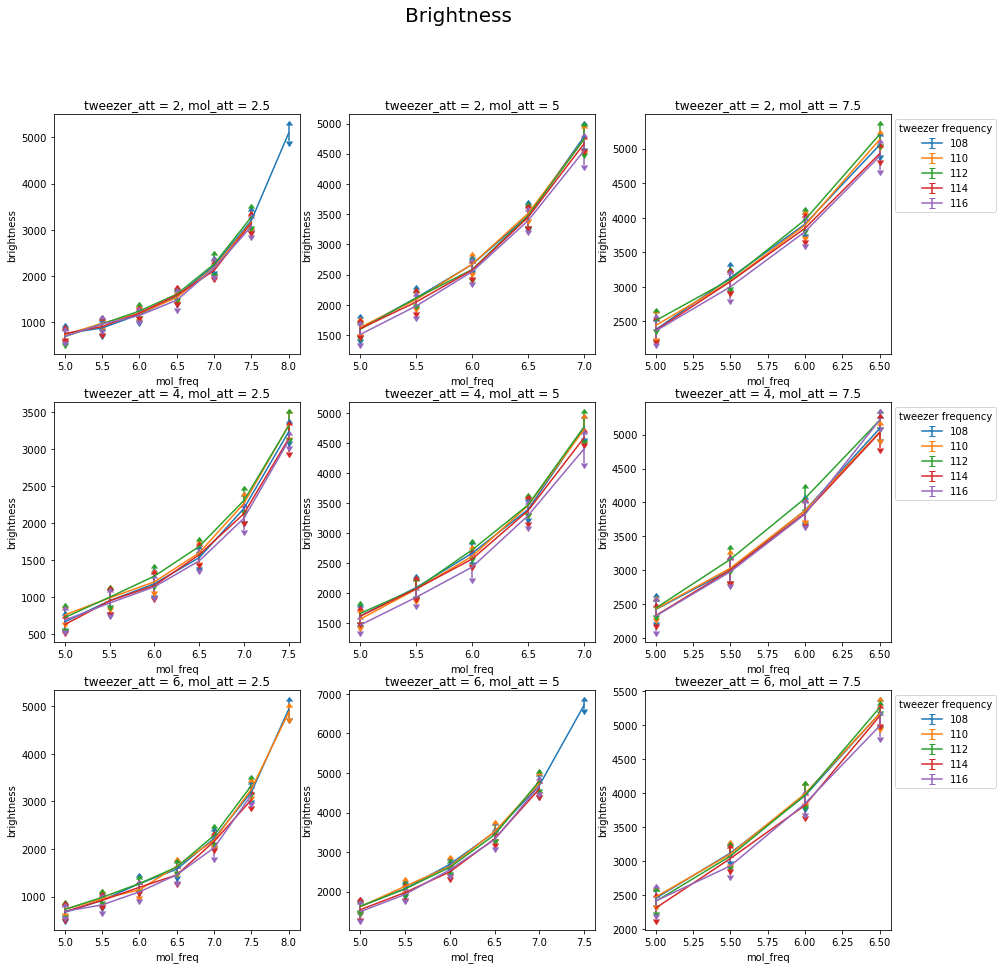

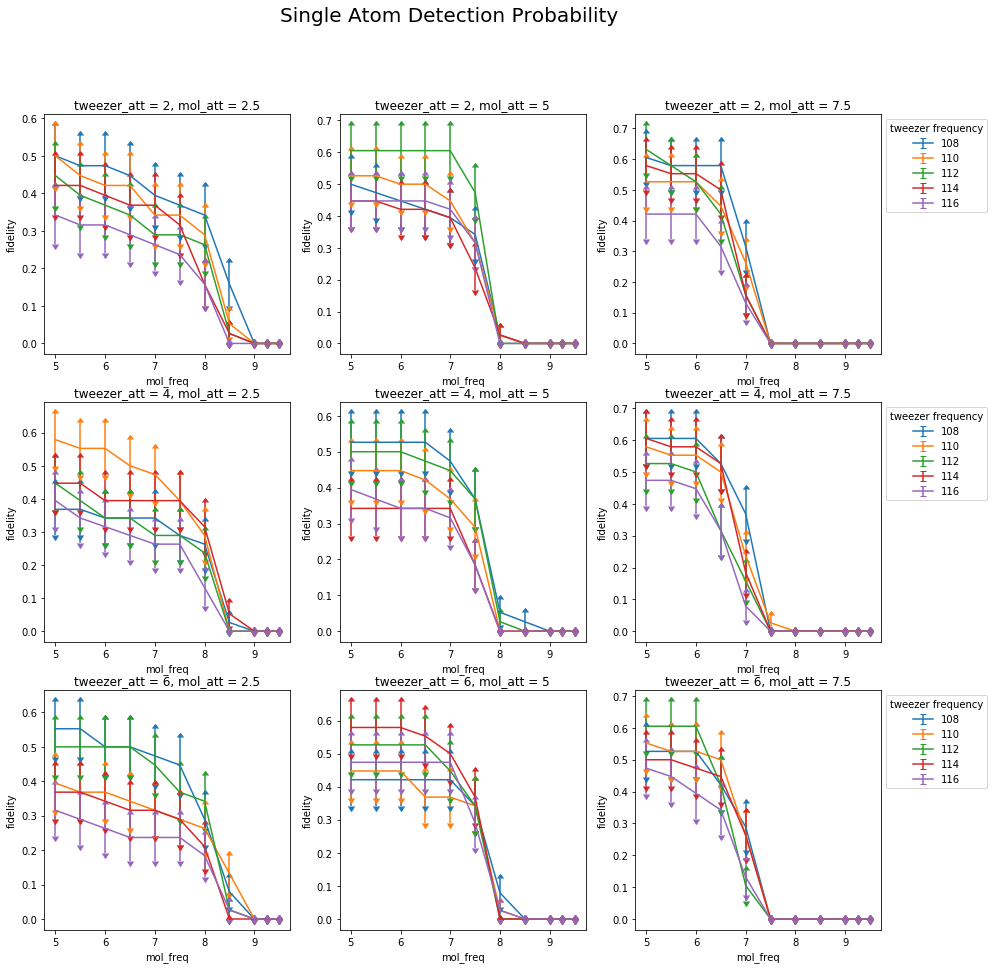

In [14]:

fig,axs = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
fig2,axs2 = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
fig.suptitle("Brightness", size = 20)
fig2.suptitle("Single Atom Detection Probability", size = 20)
for tweezer_att_counter, tweezer_att in enumerate(tweezer_att_list):
    for mol_att_counter, mol_att in enumerate(mol_att_list):
        axs[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        axs2[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        axs[tweezer_att_counter,mol_att_counter].set_xlabel('mol_freq')
        axs[tweezer_att_counter,mol_att_counter].set_ylabel('brightness')
        axs2[tweezer_att_counter,mol_att_counter].set_xlabel('mol_freq')
        axs2[tweezer_att_counter,mol_att_counter].set_ylabel('fidelity')    

        for tweezer_counter in range(len(tweezer_freq_list)):
            axs[tweezer_att_counter,mol_att_counter].errorbar(np.array(mol_freq_list), nocav_brightness_mean[:, mol_att_counter, tweezer_att_counter, tweezer_counter], \
                        yerr = nocav_brightness_sigma[:, mol_att_counter, tweezer_att_counter, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')
            axs2[tweezer_att_counter,mol_att_counter].errorbar(np.array(mol_freq_list), nocav_fidelity_mean[:, mol_att_counter, tweezer_att_counter, tweezer_counter], \
                        yerr = nocav_fidelity_sigma[:, mol_att_counter, tweezer_att_counter, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}')

    axs[tweezer_att_counter,2].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
    axs2[tweezer_att_counter,2].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')

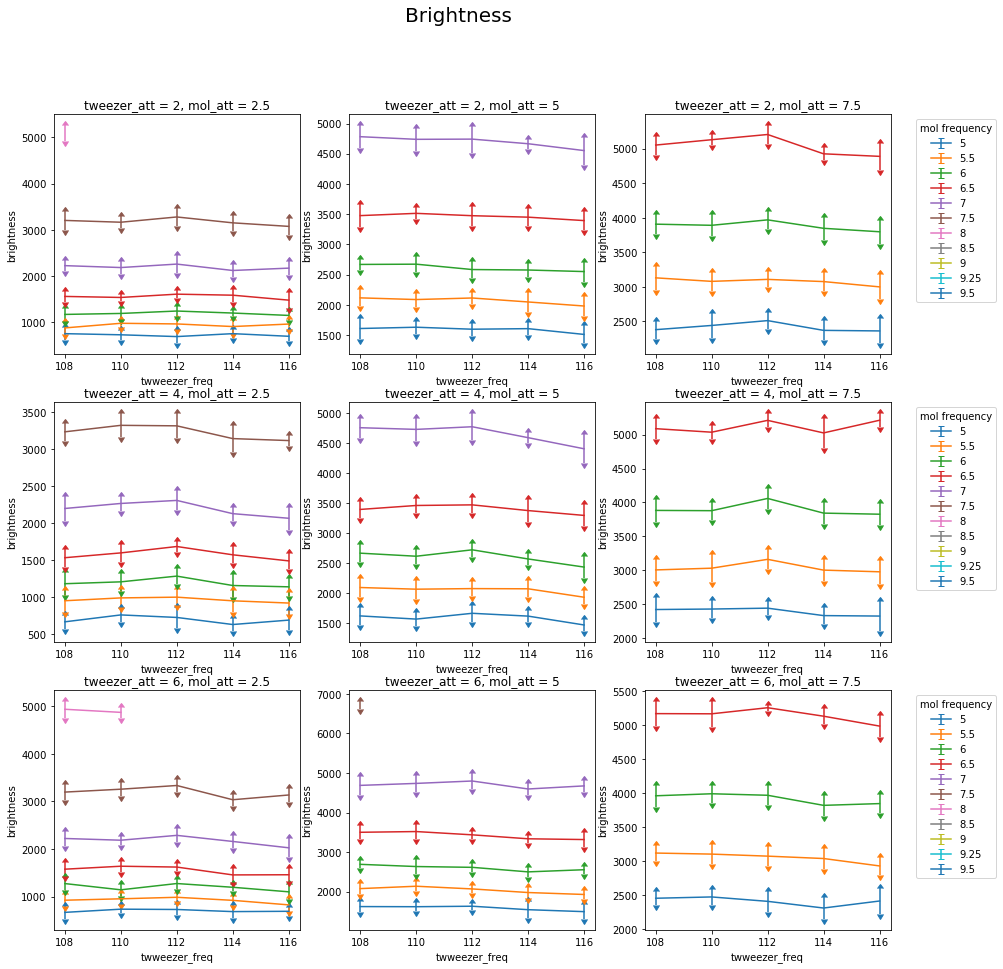

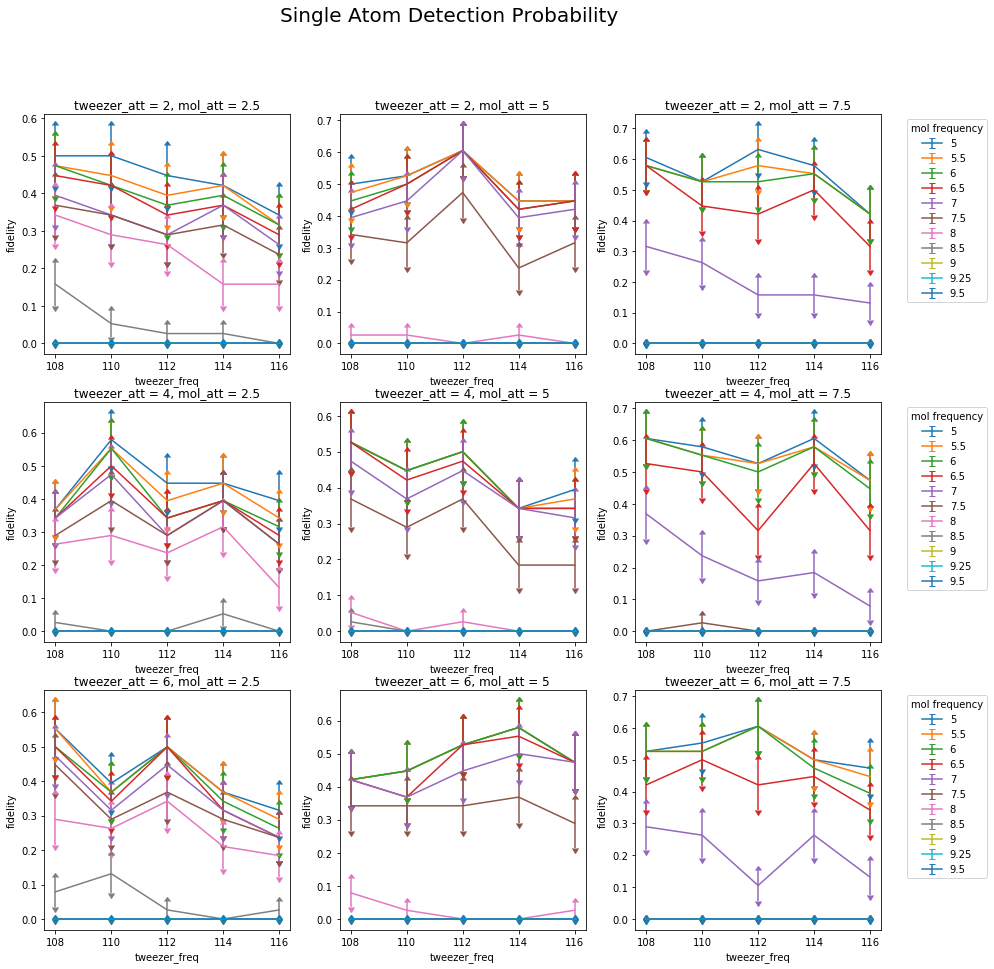

In [15]:

fig,axs = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
fig2,axs2 = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
fig.suptitle("Brightness", size = 20)
fig2.suptitle("Single Atom Detection Probability", size = 20)
for tweezer_att_counter, tweezer_att in enumerate(tweezer_att_list):
    for mol_att_counter, mol_att in enumerate(mol_att_list):
        axs[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        axs2[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        axs[tweezer_att_counter,mol_att_counter].set_xlabel('twweezer_freq')
        axs[tweezer_att_counter,mol_att_counter].set_ylabel('brightness')
        axs2[tweezer_att_counter,mol_att_counter].set_xlabel('tweezer_freq')
        axs2[tweezer_att_counter,mol_att_counter].set_ylabel('fidelity')    

        for mol_counter in range(len(mol_freq_list)):
            axs[tweezer_att_counter,mol_att_counter].errorbar(np.array(tweezer_freq_list), nocav_brightness_mean[mol_counter, mol_att_counter, tweezer_att_counter, :], \
                        yerr = nocav_brightness_sigma[mol_counter, mol_att_counter,tweezer_att_counter, :],  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
            axs2[tweezer_att_counter,mol_att_counter].errorbar(np.array(tweezer_freq_list), nocav_fidelity_mean[mol_counter, mol_att_counter, tweezer_att_counter, :], \
                        yerr = nocav_fidelity_sigma[mol_counter, mol_att_counter, tweezer_att_counter, :],  uplims=True, lolims=True, label= f'{mol_freq_list[mol_counter]}')
    
    axs[tweezer_att_counter,2].legend(title='mol frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
    axs2[tweezer_att_counter,2].legend(title='mol frequency', bbox_to_anchor=(1.45, 1), loc='upper right')

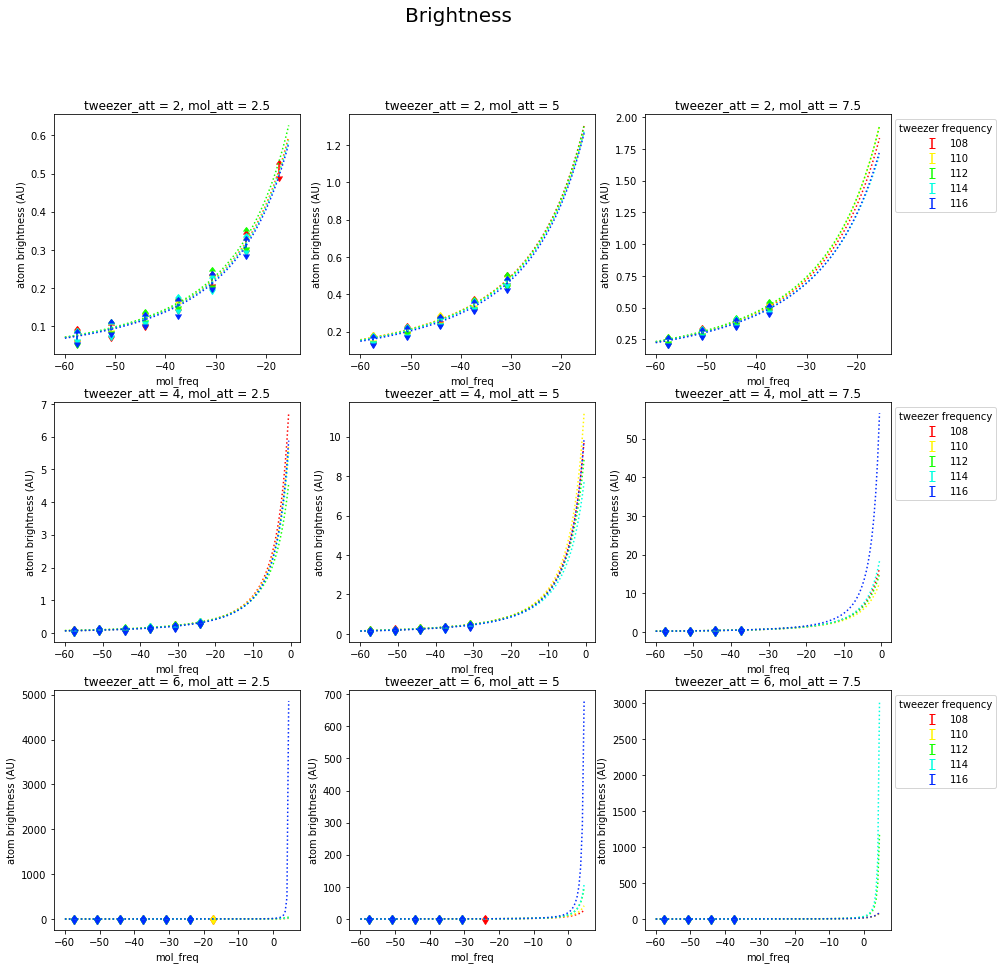

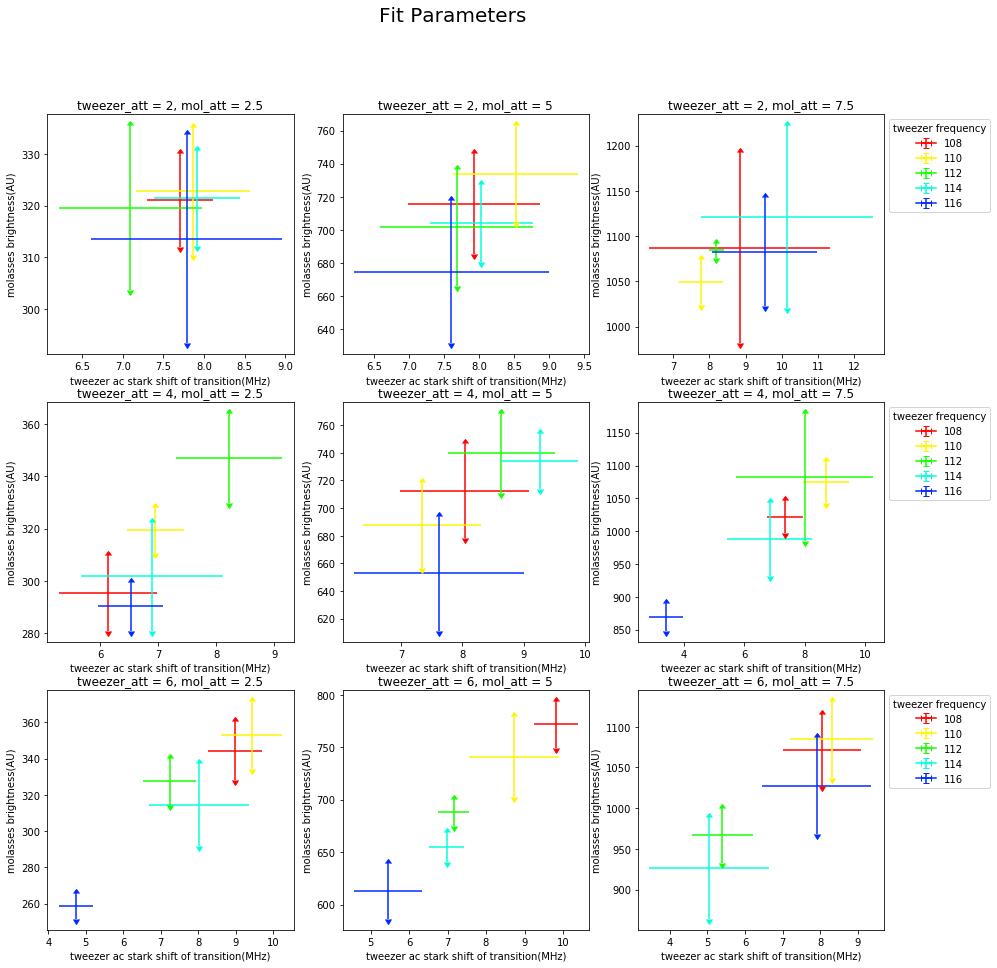

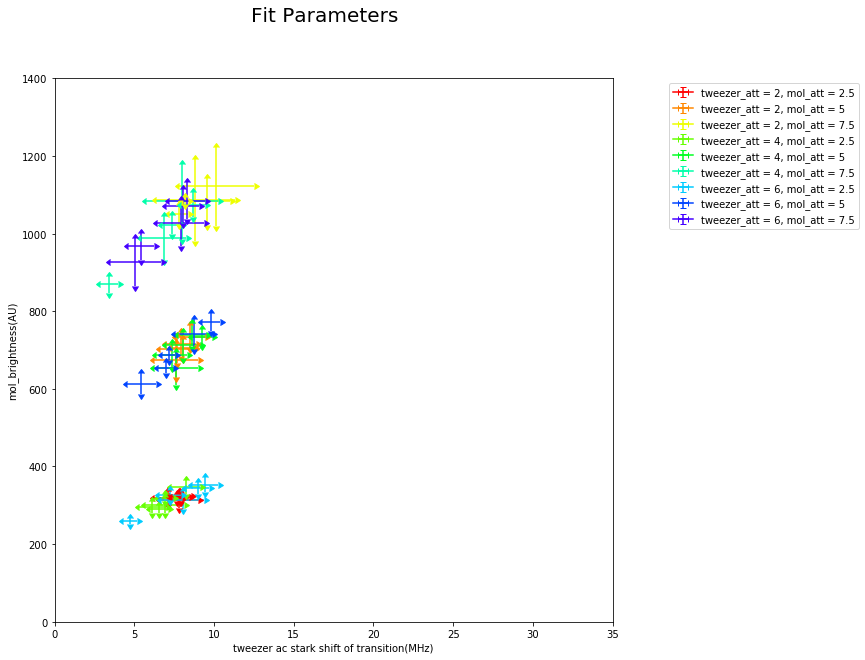

In [16]:
stark_mag = 13.5
def stark_shift(cicero):
    return -210 + 2*(6.69*cicero+42.8)
int_mag = 0.0001
def func(x, a, center):
    return  a / (x-center)**2

fig,axs = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
fig2,axs2 = plt.subplots(len(tweezer_att_list),len(mol_att_list), figsize=(15,15))
fig3,ax3 = plt.subplots(1,1, figsize=(10,10))
fig.suptitle("Brightness", size = 20)
fig2.suptitle("Fit Parameters", size = 20)
fig3.suptitle("Fit Parameters", size = 20)
ax3.set_xlim(0,35)
ax3.set_ylim(0,1400)
ax3.set_xlabel('tweezer ac stark shift of transition(MHz)')
ax3.set_ylabel('mol_brightness(AU)') 
plot_xrange_end = [-15,0,5]
for tweezer_att_counter, tweezer_att in enumerate(tweezer_att_list):
    for mol_att_counter, mol_att in enumerate(mol_att_list):
        axs[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        axs2[tweezer_att_counter,mol_att_counter].set_title(f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
        axs[tweezer_att_counter,mol_att_counter].set_xlabel('mol_freq')
        axs[tweezer_att_counter,mol_att_counter].set_ylabel('atom brightness (AU)')
        axs2[tweezer_att_counter,mol_att_counter].set_xlabel('tweezer ac stark shift of transition(MHz)')
        axs2[tweezer_att_counter,mol_att_counter].set_ylabel('molasses brightness(AU)')    

        point = tweezer_att_counter*len(mol_att_list)+mol_att_counter
        color3 = colorsys.hsv_to_rgb(0.8*point/num_points,1,1)
        for tweezer_counter in range(len(tweezer_freq_list)):
            color1 = colorsys.hsv_to_rgb(0.8*tweezer_counter/len(tweezer_freq_list),1,1)
            x_dat = stark_shift(np.array(mol_freq_list))
            y_dat = int_mag * nocav_brightness_mean[:, mol_att_counter, tweezer_att_counter, tweezer_counter]   
            sigma_y_dat = int_mag * nocav_brightness_sigma[:, mol_att_counter, tweezer_att_counter, tweezer_counter]     
            axs[tweezer_att_counter,mol_att_counter].errorbar(x_dat, y_dat, \
                        yerr = sigma_y_dat, uplims=True, lolims=True, \
                        color = color1, ls = '', label= f'{tweezer_freq_list[tweezer_counter]}')
            mask = ~(np.isnan(y_dat) |\
                     np.isnan(sigma_y_dat) )
            if np.count_nonzero(mask)>1:
                popt, pcov = curve_fit(func, x_dat[mask], y_dat[mask],\
#                                        sigma = sigma_y_dat[mask],\
                                       p0=[300, 30], maxfev = 100000)
                a_nocav, center_nocav = popt

                sigma_center_nocav = np.sqrt(pcov[1,1])
                sigma_a_nocav = np.sqrt(pcov[0,0])
                xx = np.arange(-60,plot_xrange_end[tweezer_att_counter],0.5)
                yy = func(xx,a_nocav,center_nocav)
                axs[tweezer_att_counter,mol_att_counter].plot(xx,yy,\
                        color = color1, ls = ':')
                axs2[tweezer_att_counter,mol_att_counter].errorbar(center_nocav, a_nocav,\
                                                                   xerr=sigma_center_nocav, yerr=sigma_a_nocav,\
                                                                   uplims=True, lolims=True, \
                                                                   color = color1,\
                                                                   label= f'{tweezer_freq_list[tweezer_counter]}')
                if tweezer_counter == 1:
                    ax3.errorbar(center_nocav, a_nocav,\
                                 xerr=sigma_center_nocav, yerr=sigma_a_nocav,\
                                 uplims=True, lolims=True, xlolims=True, xuplims=True,\
                                 color = color3, label= f"tweezer_att = {tweezer_att}, mol_att = {mol_att}")
                else:
                    ax3.errorbar(center_nocav, a_nocav,\
                                 xerr=sigma_center_nocav, yerr=sigma_a_nocav,\
                                 uplims=True, lolims=True, xlolims=True, xuplims=True,\
                                 color = color3)
                    
    axs[tweezer_att_counter,2].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
    axs2[tweezer_att_counter,2].legend(title='tweezer frequency', bbox_to_anchor=(1.45, 1), loc='upper right')
    ax3.legend(title='', bbox_to_anchor=(1.45, 1), loc='upper right')